# MODELAGEM

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb # Necessária para utilizar o algoritmo XGBoost
from sklearn.ensemble import RandomForestRegressor # Necessária para utilizar o algoritmo RandomForestRegressor
from sklearn.metrics import mean_squared_error # A métrica de avaliação dos modelos
from sklearn.model_selection import TimeSeriesSplit # Divisão dos dados de Treino/Validação no modelo de Séries Temporais

In [2]:
df_station = pd.read_csv('database_23ST_preprocessed.csv',index_col='time',parse_dates=True)

### SEPARAÇÃO DOS DADOS

In [3]:
'''
Separação dos dados em TREINO e TESTE:
- Serão utilizados 100 dias como base de teste.
'''

X_train = df_station[:-100].drop('sum_entries_exits',axis=1)
y_train = df_station[:-100].sum_entries_exits

X_test = df_station.iloc[-100:].drop('sum_entries_exits',axis=1)
y_test = df_station.iloc[-100:].sum_entries_exits

### CROSS-VALIDATION

In [4]:
'''
Processo de Cross-Validation dos modelos:
- Será utilizada a base de TREINO (X_train e y_train).
- O número de folds utilizado foi 10, pensando na validação estatística.
- O conjunto de validação foi definido com o mesmo tamanho do conjunto de teste (200 dias).
- Os algoritmos utilizados foram: XGBoost e RandomForest, ambos como regressores. Esses algoritmos
foram pensados pois ambos possuem internamente cálculo para importância das features, tendo como maior 
diferença entre eles o modo como o ensemble é criado, uma vez que o XGBoost utiliza a técnica BOOSTING
(técnica de reamostragem de features) para criação de seus estimadores, já o RandomForest utiliza
a técnica BAGGING (técninca de reamostragem de amostras) para criação de seus estimadores.
- A métrica utilizada para validação dos modelos foi RMSE (root mean squared error) pensando 
na avaliação dos modelos na mesma unidade que nossa variável dependente, além da vantagem de 
penalizar modelos com maiores diferenças entre valores preditos e os valores reais.
- Parâmetro do número de estimadores de ambos os ensembles (XGBoost e RF) foi setado em 1000 apenas para
padronização, nenhum tuning foi realizado neste parâmetro.
'''


cross_val_time_series = TimeSeriesSplit(n_splits=10, test_size=100) # definindo método de Cross-Validation

scores_xgb = [] # vetor de scores (RMSE) do xgboost
scores_rf = [] # vetor de scores (RMSE) do rf

for train_idx, val_idx in tqdm(cross_val_time_series.split(X_train)): # loop para Cross-Validation em cada FOLD
    
    X_train_aux = X_train.iloc[train_idx] # Conjunto de Treino em cada fold
    y_train_aux = y_train.iloc[train_idx] # Target de Treino em cada fold
    X_val = X_train.iloc[val_idx] # Conjunto Validação em cada fold
    y_val = y_train.iloc[val_idx] # Conjuto Validação em cada fold
    
    xgboost_regressor = xgb.XGBRegressor(n_estimators=1000) # Definição do modelo XGBoost
    rf_regressor = RandomForestRegressor(n_estimators=1000) # Definição do modelo RF
    
    xgboost_regressor.fit(X_train_aux, y_train_aux) # Treinando o XGBoost
    rf_regressor.fit(X_train_aux,y_train_aux) # Treinando o RF
    
    y_pred_xgb = xgboost_regressor.predict(X_val) # Valores preditos pelo XGBoost
    y_pred_rf = rf_regressor.predict(X_val) # Valores preditos pelo RF
    
    scores_xgb.append(np.sqrt(mean_squared_error(y_val, y_pred_xgb))) # Score (RMSE) do XGBoost 
    scores_rf.append(np.sqrt(mean_squared_error(y_val, y_pred_rf))) # Score (RMSE) do RF

10it [00:57,  5.74s/it]


### Colaborando com nossas análises prévias, ambos os modelos identificaram as novas features YEAR e DAY_OF_YEAR como sendo as mais importantes para realização da previsão da nossa variável SUM_ENTRIES_EXITS

#### Feature Importance:

- XGBoost:

In [5]:
pd.DataFrame([xgboost_regressor.feature_importances_], columns=xgboost_regressor.feature_names_in_)

,year,quarter,month,day_of_week,day_of_year
0,0.97247,0.000141,0.001824,0.001621,0.023943


- Random Forest:

In [6]:
pd.DataFrame([rf_regressor.feature_importances_],columns=rf_regressor.feature_names_in_)

,year,quarter,month,day_of_week,day_of_year
0,0.952657,0.000623,0.000991,0.001647,0.044082


# VALIDAÇÃO ESTATÍSTICA

### Existe diferença estatisticamente significativa entre a performace dos dois modelos utilizados?

In [7]:
from scipy.stats import kstest, shapiro # Teste de Normalidade dos vetores de performace dos modelos

#### Utilizaremos dois testes de Normalidade da distribuição dos vetores:
- Kolmogorov-Smirnov: Se p-valor < 0.05 (nível de significância do teste), rejeitamos a hipótese nula de que a distribuição do vetor analisado segue uma distribuição normal.
- Shapiro-Wilk: Se p-valor < 0.05 (nível de significância do teste), rejeitamos a hipótese nula de que a distribuição do vetor analisado segue uma distribuição normal.

#### Utilizamos esses dois testes para garantirmos se utilizaremos testes PARAMÉTRICOS ou NÃO-PARAMÉTRICOS para calcularmos a diferença estatística entre a performace dos dois modelos.

- XGBoost:

In [8]:
kstest(scores_xgb,'norm'),shapiro(scores_xgb)

(KstestResult(statistic=1.0, pvalue=0.0),
 ShapiroResult(statistic=0.859565258026123, pvalue=0.07541303336620331))

- Random Forest:

In [9]:
kstest(scores_rf,'norm'),shapiro(scores_rf)

(KstestResult(statistic=1.0, pvalue=0.0),
 ShapiroResult(statistic=0.8376548290252686, pvalue=0.04135814681649208))

#### Como em ambos os testes nós rejeitamos a hipótese que a distribuição dos vetores de performace dos modelos se distribuem de acordo com a distribuição NORMAL, utilizaremos teste NÃO-PARAMÉTRICO para comparação das performances dos modelos.

#### Utilizaremos o teste de Wilcoxon:
- Wilcoxon: Se p-valor < 0.05 (nível de significância do teste), rejeitamos a hipótese nula de que x - y = 0, ou seja, que os vetores vem da mesma distribuição.

In [10]:
from scipy.stats import wilcoxon # Teste não-paramétrico para comparação da performace dos modelos

In [11]:
wilcoxon(scores_xgb,scores_rf) # não rejeita a hipotese que os vetores vêm da mesma distribuição

WilcoxonResult(statistic=11.0, pvalue=0.10546875)

#### Como verificamos, pelo teste de Wilcoxon, não existe diferença estatisticamente significativa entre a performace dos modelos utilizados, iremos analisar a performace de ambos na previsão das amostras do conjunto de teste.

# PREVISÃO DA BASE DE TESTE

In [12]:
xgboost_regressor = xgb.XGBRegressor(n_estimators=1000) # Definindo XGBoost
rf_regressor = RandomForestRegressor(n_estimators=1000) # Definindo RF

xgboost_regressor.fit(X_train, y_train) # Treinando XGBoost em toda base de TREINO
rf_regressor.fit(X_train, y_train) # Treinando RF em toda base de TREINO

y_pred_xgb = xgboost_regressor.predict(X_test) # Valores preditos por XGBoost da base de TESTE
y_pred_rf = rf_regressor.predict(X_test) # Valores preditos por RF da base de TESTE    

In [13]:
''' Criação do DF de comparação entre as performaces dos modelos e o valor real da variável dependente'''

df_comparison = pd.DataFrame([y_test.values,y_pred_xgb,y_pred_rf]).T
df_comparison.columns = ['y_test','y_pred_xgb','y_pred_rf']
df_comparison.index = y_test.index
df_comparison.head()

,y_test,y_pred_xgb,y_pred_rf
time,,,
2017-06-16,4.506452e+10,4.484470e+10,4.424934e+10
2017-06-17,4.521487e+10,4.447139e+10,4.260783e+10
2017-06-18,4.596410e+10,4.444648e+10,3.989462e+10
2017-06-19,4.596445e+10,4.636565e+10,4.447959e+10
2017-06-20,4.596508e+10,4.559545e+10,4.443182e+10


<IPython.core.display.Javascript object>


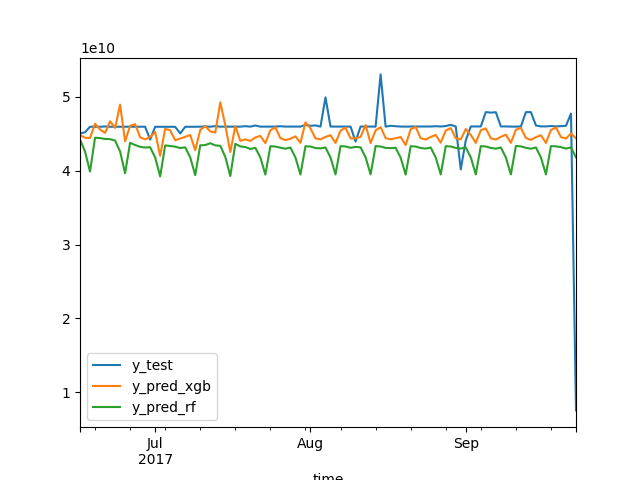

<AxesSubplot:xlabel='time'>

In [14]:
%matplotlib notebook
df_comparison.plot()

#### Cálculo do RMSE dos modelos na base de teste.

- XGBoost:

In [15]:
np.sqrt(mean_squared_error(y_val, y_pred_xgb))

8346519828.003116

- RF:

In [16]:
np.sqrt(mean_squared_error(y_val, y_pred_rf))

6698201231.408091

# CONCLUSÕES

- Como podemos ver, de acordo com o RMSE, apesar de não apresentar uma performace estatisticamente significativa diferente do XGBoost, o regressor Random Forest obteve uma melhor performace no conjunto de TESTE do que o regressor XGBoost.
- Ainda existe muito espaço para melhora da performace de ambos os modelos, como podemos identificar na série temporal do conjunto de teste em comparação com a previsão dos modelos. Algumas técnicas são sugeridas para melhora desses modelos, como próximos passos.